In [1]:
## Evaluation the annotations by giving an image with

## Two images in a row: [REFLACX annotations, our radiologists annotations]

In [2]:
import os, gc, torch
import os 

import numpy as np
import pandas as pd
# from models.load import TrainedModels

from models.load import get_trained_model
from data.datasets import  OurRadiologsitsDataset, collate_fn
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS
import PIL
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import trange
from our_radiologist.load import get_anns

from typing import Callable, Dict, List, Union, Tuple
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors
from utils.pred import pred_thrs_check
from data.datasets import ReflacxDataset, collate_fn
from utils.plot import DISEASE_CMAP, get_legend_elements
from models.train import TrainingInfo
from data.load  import seed_worker, get_dataloader_g

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
# plt.ioff()

In [3]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])

In [4]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [5]:
dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": False,
        "dataset_mode": "normal",
        "bbox_to_mask": False,
        "normalise_clinical_num": False,
        "labels_cols": DEFAULT_REFLACX_LABEL_COLS,
    }
    
detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=4,
)

legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

radiologists_ann = get_anns("radiologists_annotated", detect_eval_dataset)

radiologist_dataset = OurRadiologsitsDataset(
    detect_eval_dataset, radiologists_ann
)

In [6]:
def plot_targets_for_dataset_idx(
    radiolgist_dataset,
    reflacx_dataset: ReflacxDataset,
    device: str,
    idx: int,
    legend_elements: List[Line2D],
    disease_cmap=DISEASE_CMAP,
) -> Tuple[Figure, Union[Figure, None]]:
    # change all the model to eval mode.

    ## retrieve the data, and transform them into input.
    # this dataset has to be the one with clinical.
    
    our_data = collate_fn([radiologist_dataset[idx]])
    our_data = radiologist_dataset.prepare_input_from_data(our_data, device)
    _,  our_target = our_data
    reflacx_ids = reflacx_dataset.get_idxs_from_dicom_id(our_target[0]['dicom_id'])

    reflacx_targets = []
    for reflacx_id in  reflacx_ids:
        reflacx_data = collate_fn([reflacx_dataset[idx]])
        reflacx_data = reflacx_dataset.prepare_input_from_data(reflacx_data, device)
        _, reflacx_target = reflacx_data
        reflacx_targets.append(reflacx_target)
    
    bb_figs = [plot_bbox_for_target(
        idx=idx,
        encoding=our_target[0]['encoding'],
        our_target= our_target[0],
        reflacx_target=r_t[0],
        label_idx_to_disease=reflacx_dataset.label_idx_to_disease,
        legend_elements=legend_elements,
        disease_color_code_map=disease_cmap["solid"],
    ) for r_t in reflacx_targets]

    return bb_figs


def plot_bbox_for_target(
    idx: int,
    encoding: str,
    our_target: Dict,
    reflacx_target: Dict,
    label_idx_to_disease: Callable[[int], str],
    legend_elements: List[Line2D],
    disease_color_code_map: Dict[str, str],
) -> Figure:
    # clinical + original image + preds

    slot_size = 2
    task_idx = 0

    # prepare the figure
    fig, axes = plt.subplots(
        1, slot_size, figsize=(slot_size * 10, 10), dpi=120, sharex=True
    )
    img_path = our_target["image_path"]
    dicom_id = os.path.basename(img_path)
    fig.suptitle(f"{dicom_id} ({idx})")
    fig.legend(handles=legend_elements, loc="upper right")
    img = PIL.Image.open(our_target["image_path"]).convert("RGB")

    # show the image in every matrix except the clinical.

    ## take the order. it should be [clinical data, 3d clinical image, original image, other predictions...]

    for ax in axes:
        ax.imshow(img)

    # plot reflacx.
    axes[task_idx].set_title(
        f"REFLACX Ground Truth ({len(reflacx_target['boxes'].detach().cpu().numpy())})"
    )
    for label, bbox in zip(
        reflacx_target["labels"].detach().cpu().numpy(),
        reflacx_target["boxes"].detach().cpu().numpy(),
    ):
        disease = label_idx_to_disease(label)
        c = disease_color_code_map[disease]
        axes[task_idx].add_patch(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        axes[task_idx].text(
            bbox[0], bbox[1], disease, color="black", backgroundcolor=c
        )
    task_idx += 1
        
    axes[task_idx].set_title(
        f"Our Ground Truth ({len(our_target['boxes'].detach().cpu().numpy())})"
    )
    for label, bbox in zip(
        our_target["labels"].detach().cpu().numpy(),
        our_target["boxes"].detach().cpu().numpy(),
    ):
        disease = label_idx_to_disease(label)
        c = disease_color_code_map[disease]
        axes[task_idx].add_patch(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        axes[task_idx].text(
            bbox[0], bbox[1], disease, color="black", backgroundcolor=c
        )

    return fig

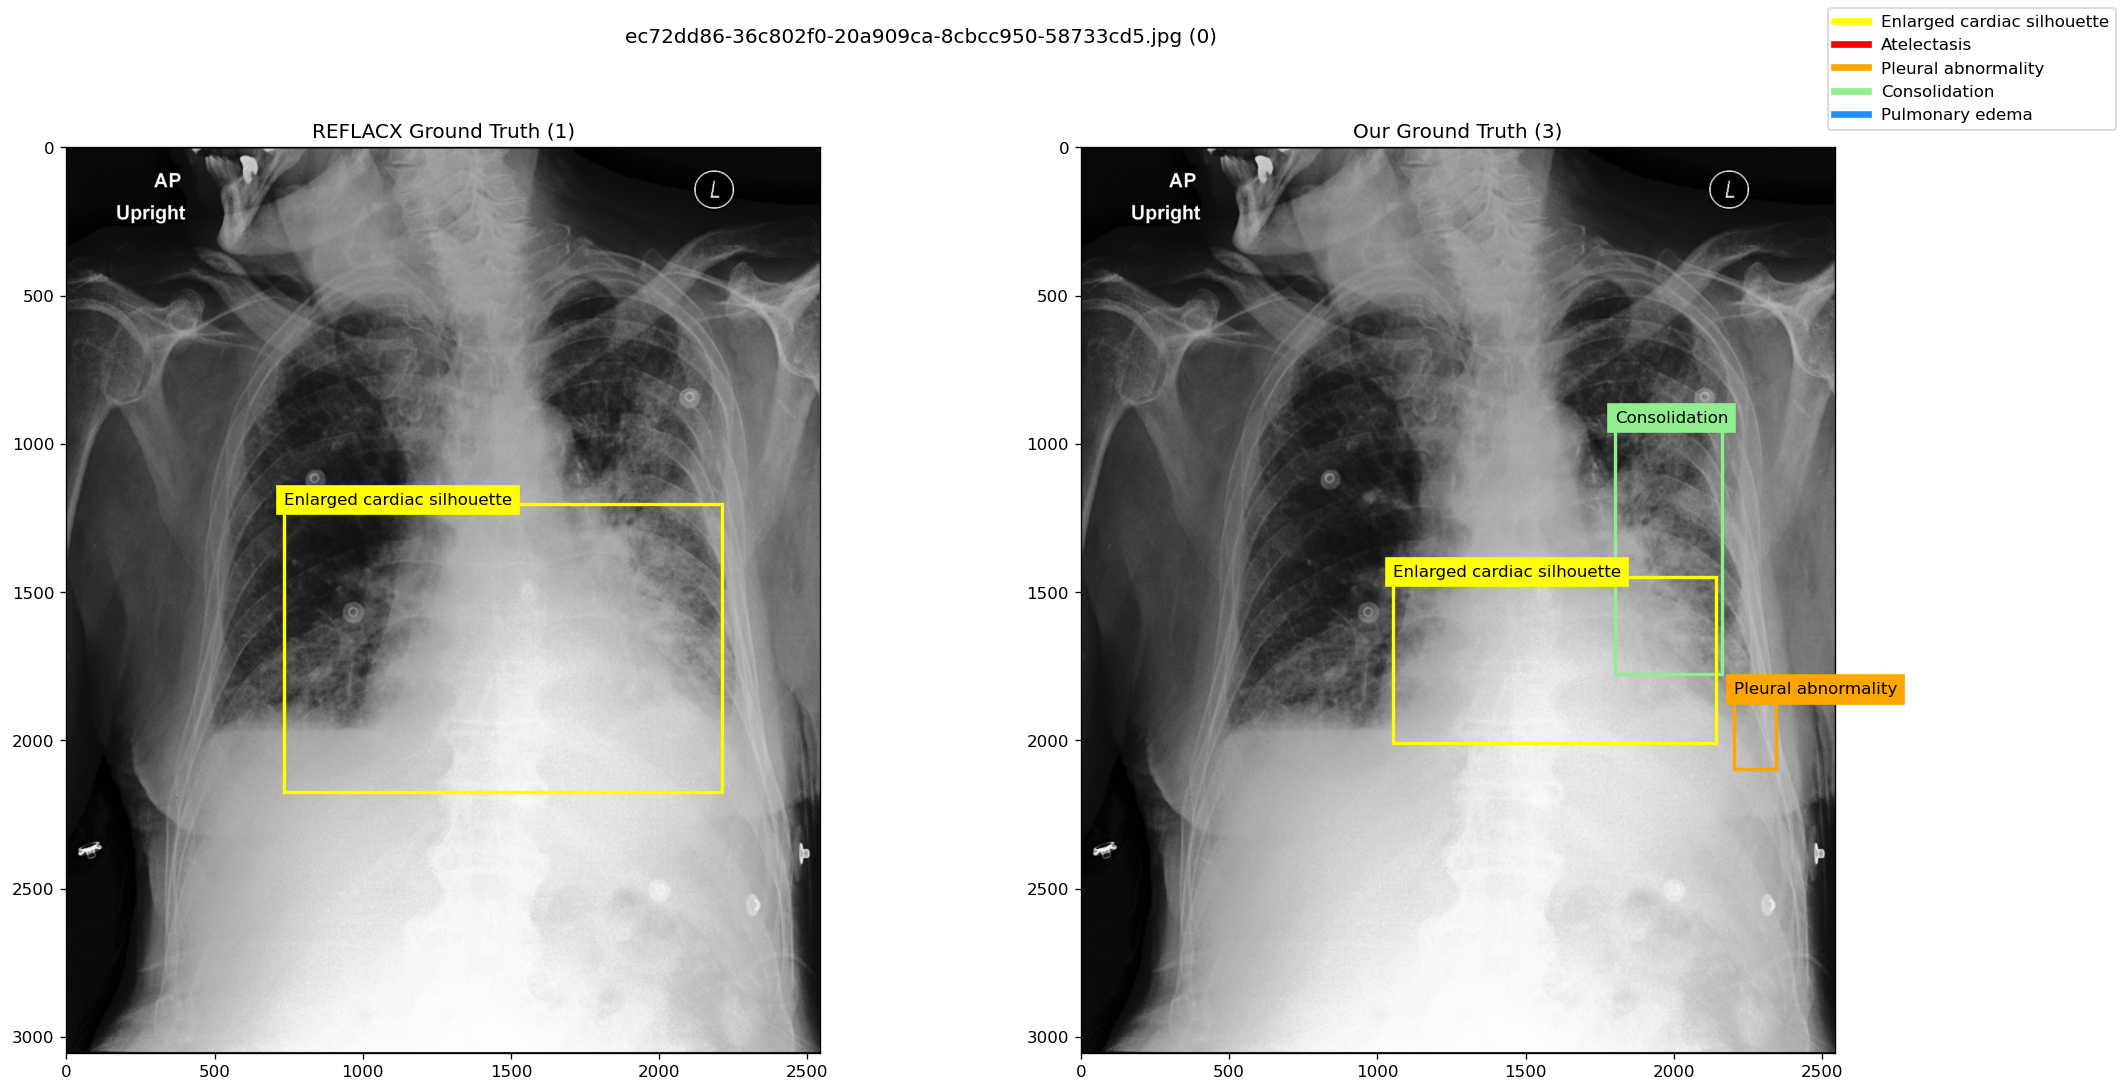

In [7]:
# for generating the example in the paper.
fig = plot_targets_for_dataset_idx(
        radiolgist_dataset=radiologist_dataset,
        reflacx_dataset=detect_eval_dataset,
        device=device,
        idx=0,
        legend_elements=legend_elements,
        disease_cmap=DISEASE_CMAP,
    )

In [8]:
### modify the naming here.
destination_folder = os.path.join(
    "reflacx_vs_our", 
)
os.makedirs(destination_folder, exist_ok=True)

for idx in trange(0, len(radiologist_dataset)):
    figs = plot_targets_for_dataset_idx(
            radiolgist_dataset=radiologist_dataset,
            reflacx_dataset=detect_eval_dataset,
            device=device,
            idx=idx,
            legend_elements=legend_elements,
            disease_cmap=DISEASE_CMAP,
        )

    _, target = radiologist_dataset[idx]
    

    for f_i, f in enumerate(figs):
        f.savefig(
            os.path.join(
                destination_folder,
                f"{target['encoding']}_{target['dicom_id']}-{f_i}.png",
            )
        ) 

    plt.cla()
    plt.clf()
    plt.close("all")


100%|██████████| 24/24 [00:54<00:00,  2.26s/it]
